In [1]:
import pickle

load_path = "/content/drive/MyDrive/processed_faces_final/sampled_frames.pkl"

with open(load_path, "rb") as f:
    data = pickle.load(f)

real_sampled = data["real"]
fake_sampled = data["fake"]

print(f"Loaded Real Frames: {len(real_sampled)}")
print(f"Loaded Fake Frames: {len(fake_sampled)}")


Loaded Real Frames: 10000
Loaded Fake Frames: 9988


In [2]:
from torch.utils.data import Dataset
from PIL import Image
import cv2

class DeepfakeDataset(Dataset):
    def __init__(self, frame_paths, label, transform=None):
        self.frame_paths = frame_paths
        self.labels = [label] * len(frame_paths)
        self.transform = transform

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        img_path = self.frame_paths[idx]

        # Albumentations works with NumPy arrays (BGR format for OpenCV)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        if self.transform:
            image = self.transform(image=image)["image"]  # Albumentations returns a dict

        return image, self.labels[idx]


In [3]:
#splitting

from sklearn.model_selection import train_test_split
import os

def split_video_wise(frames, test_size=0.15, val_size=0.15):
    # Extract video folder name from path
    video_folders = list(set([os.path.dirname(p) for p in frames]))

    train_videos, temp_videos = train_test_split(video_folders, test_size=(test_size + val_size), random_state=42)
    val_videos, test_videos = train_test_split(temp_videos, test_size=(test_size/(test_size + val_size)), random_state=42)

    def filter_by_video(video_list):
        return [p for p in frames if os.path.dirname(p) in video_list]

    return filter_by_video(train_videos), filter_by_video(val_videos), filter_by_video(test_videos)

real_train, real_val, real_test = split_video_wise(real_sampled)
fake_train, fake_val, fake_test = split_video_wise(fake_sampled)

print(len(real_train), len(real_val), len(real_test))
print(len(fake_train), len(fake_val), len(fake_test))


7000 1500 1500
6997 1500 1491


In [4]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import ConcatDataset, DataLoader


In [5]:
def get_model(dropout_rate=0.3, num_classes=2, freeze_ratio=0.8):
    # Load pretrained Xception model
    model = timm.create_model('xception', pretrained=True)

    # Freeze lower layers to reduce computation
    num_layers = len(list(model.parameters()))
    freeze_until = int(num_layers * freeze_ratio)

    for i, param in enumerate(model.parameters()):
        if i < freeze_until:
            param.requires_grad = False

    # Replace final classification head
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(512, num_classes)
    )

    # Move model to appropriate device (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    return model, device

In [6]:
model, device = get_model()
model.load_state_dict(torch.load("/content/drive/MyDrive/processed_faces_final/best_xception_optuna.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
✅ Model loaded successfully.


In [7]:

test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [8]:
test_dataset = ConcatDataset([
    DeepfakeDataset(real_test, 0, transform=test_transforms),
    DeepfakeDataset(fake_test, 1, transform=test_transforms)
])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"Loaded {len(test_dataset)} test frames.")


Loaded 2991 test frames.


In [10]:
criterion = nn.CrossEntropyLoss()
test_loss, correct, total = 0.0, 0, 0
all_labels, all_preds, all_probs = [], [], []

# Count total number of batches for progress display
total_batches = len(test_loader)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # --- Progress print ---
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"Processed {batch_idx}/{total_batches} batches...")

# --- Final evaluation ---
test_loss /= total
acc = correct / total
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"], digits=4)

print("\n📊 Evaluation Results")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Processed 10/94 batches...
Processed 20/94 batches...
Processed 30/94 batches...
Processed 40/94 batches...
Processed 50/94 batches...
Processed 60/94 batches...
Processed 70/94 batches...
Processed 80/94 batches...
Processed 90/94 batches...
Processed 94/94 batches...

📊 Evaluation Results
Test Loss: 0.1966
Accuracy:  0.9552
AUC:       0.9908

Confusion Matrix:
 [[1416   84]
 [  50 1441]]

Classification Report:
               precision    recall  f1-score   support

        Real     0.9659    0.9440    0.9548      1500
        Fake     0.9449    0.9665    0.9556      1491

    accuracy                         0.9552      2991
   macro avg     0.9554    0.9552    0.9552      2991
weighted avg     0.9554    0.9552    0.9552      2991



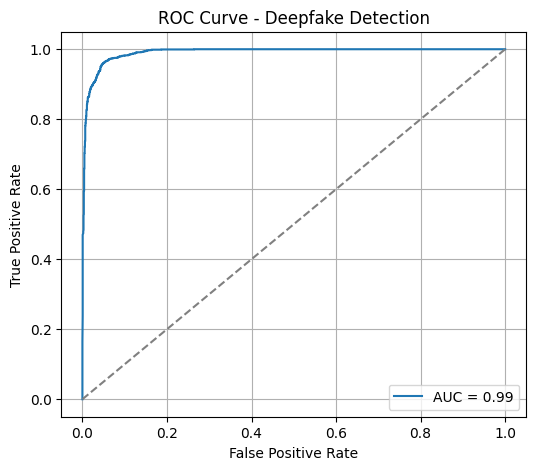

In [11]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Deepfake Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()